# Assignment 1 - Option B - Jacob Hargreaves - 2401649

### Monte Carlo simulations for modelling a particle physics experiment

This notebook simulates a beam of partickes travelling along the $z$ axis with a mean veloicty of $2000ms^{-1}$. Each decays into a daughter particle after a mean lifetime of $2.5ms$ which is then propelled out of the decay point isotropically. Four tracking stations are placed at $ z = 30, 35, 40, 45m$ and are square surfaces of side length $5m$ which detect any daughter particles incident upon them with a resolution of $\pm0.01m$. This simulation displays the positions of all particles incident upon each of the four stations and analyses the breakdown of how many particles connect with each station. 

In [102]:
# importing the relevant libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.integrate import quad
from IPython.display import Markdown


These first two functions create and decay a single particle according to the parameters given. $z$-velocity is drawn from a normal distributionn while decay time is drawn from an exponential distribution. 

In [118]:
# # generate a beam of particles with velocities selected from a normal distribution
# # set their initial positions equal to zero, working in 3D

# def generate_beam(mean_v, std_v):
#     velocity = np.array([ 0, 0, np.random.normal(mean_v, std_v)])
#     position = np.zeros((1,3))
#     return position, velocity


# # create a function that generates decay times for particles based on an exponential distribution
# # then calculates their decay positions based on their velocities and the dcay time

# def decay_position(Lambda, position, velocity):
#     d_time = np.random.exponential(Lambda)
#     decay_position_z = d_time * velocity[2]
#     position[0][2] = decay_position_z
#     return position


def generate_and_decay(N, mean_v, std_v, Lambda):

    velocities = np.random.normal(mean_v, std_v, N)

    decay_time = np.random.exponential(Lambda, N)
    decay_z_pos = decay_time * velocities

    return decay_z_pos


As each particle has it's $z$-velocity drawn from a normal distribution of mean $\mu_v = 20000ms^{-1}$ and it's decay time from an exponential distribution of mean $\tau = 2.5ms$, the mean distance travelled by a particle before decaying should be $5m$. 

The resulting distribution of the particles can be given by the probability density function of:

$$ f(z) = \int_0^\infty \frac{1}{b} N (\mu, \sigma^2) Exp(\lambda) db$$

which is equivalent to:

$$ f(z) = \frac{\lambda}{\sqrt{2 \pi \sigma}} \int_0^\infty \frac{1}{b} e^{\left(-\frac{(z/b-\mu)^2}{2\sigma^2}-\lambda b\right)}db$$

The next cell tests the two functions above to check the distribution of the decay distances of the particles and check the mean decay distance. 

The probability distribution function is multiplied by $10^6$ and plotted alongside the measured distribution to ensure the code is running correctly. 



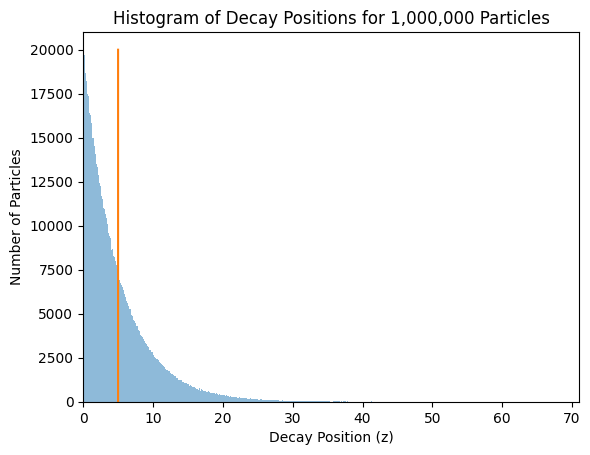

Mean Decay Distance: 5.006 m

In [104]:
num_particles = 10**6
mean_v = 2000
std_v = 50
Lambda = 0.0025
decay_positions = []

for i in range(num_particles):
    position, velocity = generate_beam(mean_v, std_v)
    decay_pos = decay_position(Lambda, position, velocity)
    decay_positions.append(decay_pos[0][2])


plt.hist(decay_positions, bins=np.arange(0, max(decay_positions), 0.1) - 0.5, alpha=0.5)
plt.plot(np.ones(20000)*5, np.arange(0,20000))
plt.xlabel('Decay Position (z)')
plt.ylabel('Number of Particles')
plt.title('Histogram of Decay Positions for 1,000,000 Particles')
plt.xlim(0, max(decay_positions))
plt.show()

mean_decay_distance = np.mean(decay_positions)

Markdown(f"Mean Decay Distance: {mean_decay_distance:.3f} m")

# do proper statistical test here to check if valid

The results above show the code runs as intended. 

These next cells create the initial direction of the daughter particle and calculate it's trajectory in the $x$ and $y$ axes. 

The initial direction of the daughter particle should be created isotropically as we are able to assume the momentum of the daughter particle is signaificantly higher than that of the parent particle. 

In [120]:
# function to select the daughter particle direction based on it being isotropic

def daughter_initial_direction(N):
    theta = np.arccos(1 - 2 * np.random.uniform(0, 1, N))
    phi = 2 * np.pi * np.random.uniform(0, 1, N)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    norm = np.sqqrt(x**2 + y**2 + z**2)
    x /= norm
    y /= norm
    z /= norm
    return x, y, z



The code in the cell below tests the output of the daughter_initial_direction function. Ensuring this is correct is crucial to the rest of the simulation as any dicrepency in the distribution will throw off further results. 

KS statistic: 0.0087
p-value: 0.4381
✓ cos(θ) is uniformly distributed (isotropic)


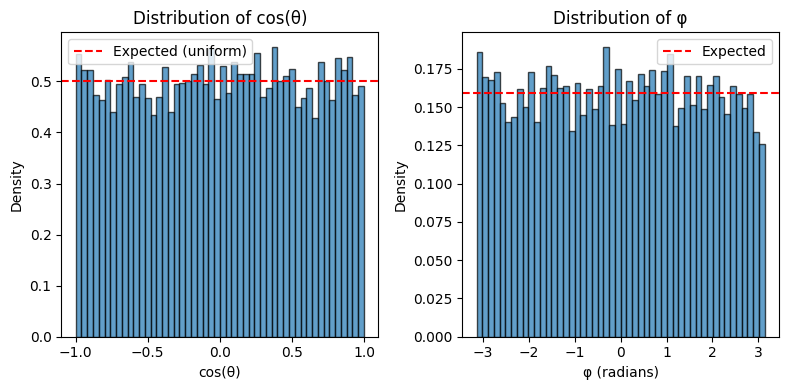

In [106]:
# Generate many directions
n_samples = 10000
directions = [daughter_initial_direction() for _ in range(n_samples)]
directions = np.array(directions)

# Extract theta (angle from z-axis)
cos_theta = directions[:, 2]  # z-component = cos(θ)

# Kolmogorov-Smirnov test for uniformity
ks_stat, p_value = stats.kstest(cos_theta, 'uniform', args=(-1, 2))  # uniform on [-1, 1]

print(f"KS statistic: {ks_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value > 0.05:
    print("✓ cos(θ) is uniformly distributed (isotropic)")
else:
    print("✗ cos(θ) is NOT uniformly distributed")

# Visual check
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(cos_theta, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axhline(y=0.5, color='r', linestyle='--', label='Expected (uniform)')
plt.xlabel('cos(θ)')
plt.ylabel('Density')
plt.title('Distribution of cos(θ)')
plt.legend()

plt.subplot(1, 3, 2)
phi = np.arctan2(directions[:, 1], directions[:, 0])
plt.hist(phi, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axhline(y=1/(2*np.pi), color='r', linestyle='--', label='Expected')
plt.xlabel('φ (radians)')
plt.ylabel('Density')
plt.title('Distribution of φ')
plt.legend()

plt.tight_layout()
plt.show()

In [121]:
# # function to track the daughter particle at each tracking station

# def daughter_position_eqn(direction, decay):

#     m_x = direction[0] / np.abs(direction[2])
#     m_y = direction[1] / np.abs(direction[2])

#     c_x = - m_x * decay[0][2]
#     c_y = - m_y * decay[0][2]

#     def x_func(z):
#         x_func = m_x * z + c_x
#         return x_func
#     def y_func(z):
#         y_func = m_y * z + c_y
#         return y_func
        
#     return x_func, y_func


def daughter_position_eqn(detector_positions, decay_z_pos, x, y, z):
    first_detector = min(detector_positions)
    valid_mask = (decay_z_pos < first_detector) & (z > 0)

    m_x = np.where(valid_mask, x / z, 0)
    m_y = np.where(valid_mask, y / z, 0)

    c_x = np.where(valid_mask, -m_x * decay_z_pos, 0)
    c_y = np.where(valid_mask, -m_y * decay_z_pos, 0)

    return m_x, m_y, c_x, c_y




In [ ]:
def check_hits(detector_positions, m_x, m_y, c_x, c_y, valid_mask):
    detector_z = np.array(detector_positions)

    x_at_detectors = m_x[:, np.newaxis] * detector_z[np.newaxis, :] + c_x[:, np.newaxis]
    y_at_detectors = m_y[:, np.newaxis] * detector_z[np.newaxis, :] + c_y[:, np.newaxis]

    x_in_bounds = (x_at_detectors > -2.5) & (x_at_detectors < 2.5)
    y_in_bounds = (y_at_detectors > -2.5) & (y_at_detectors < 2.5)

    hits = x_in_bounds & y_in_bounds & valid_mask[:, np.newaxis]
    
    


The next two cells simulate a measurement at different tracking stations with a normally distributed error of $\sigma_{x,y} = 0.01m$. 

In [ ]:
# # function to simulate errors in position measurements

# def measurement_error(error_mean, error_std):
#     error_x = np.random.normal(error_mean, error_std)
#     error_y = np.random.normal(error_mean, error_std)
#     return error_x, error_y

# ## CHANGE - add errors randomly to value as instructions give

In [109]:
# function to count detected particles and record their positions with measurement errors

def count_detected(x_func, y_func, detector_positions, hit_vector):
    
    num_hit = 0
    col_index = 0

    for z in detector_positions:

            x = x_func(z)
            y = y_func(z)
            
            if -2.5 < x < 2.5 and -2.5 < y < 2.5:
                num_hit += 1

                x_err, y_err = measurement_error(0, 0.01)
                if col_index + 5 <= len(hit_vector):
                    hit_vector[col_index:col_index+5] = [x, np.abs(x_err), y, np.abs(y_err), z]
                    col_index += 5
            
    return num_hit, hit_vector

### Add resolution to all measurements, 2dp or something

In [110]:
# function to bring all components together to run the simulation

def simulation(num_particles, mean_v, std_v, Lambda, detector_positions):
    all_hit_vectors = []
    num_hits_list = []

    for a in range(0, num_particles, 1):
        
        position, velocity = generate_beam(mean_v, std_v)
        decay = decay_position(Lambda, position, velocity)
        #direction = daughter_initial_direction()
        direction = random_isotropic_unit_vector()

        if decay[0][2] < min(detector_positions) and direction[2] > 0:

            x_func, y_func = daughter_position_eqn(direction, decay)

            hit_vector = np.zeros(20)
            num_hit, hit_vector = count_detected(x_func, y_func, detector_positions, hit_vector)
            all_hit_vectors.append(hit_vector)
            num_hits_list.append(num_hit)

        else:
            all_hit_vectors.append(np.zeros(20))
            num_hits_list.append(0)


    column_names = ['x1', 'x1_err', 'y1', 'y1_err', 'z1', 'x2', 'x2_err', 'y2', 'y2_err', 'z2', 
                    'x3', 'x3_err', 'y3', 'y3_err', 'z3', 'x4', 'x4_err', 'y4', 'y4_err', 'z4']
    df = pd.DataFrame(all_hit_vectors, columns=column_names)
    
    return df, num_hits_list

In [111]:
#running the simulation with the given parameters

num_particles = 10**6
mean_v = 2000
std_v = 50
Lambda = 0.0025
detector_positions = [30, 35, 40, 45]

run, num_hits_list = simulation(num_particles, mean_v, std_v, Lambda, detector_positions)
run

# print(num_hits_list)
    

,x1,x1_err,y1,y1_err,z1,x2,x2_err,y2,y2_err,z2,x3,x3_err,y3,y3_err,z3,x4,x4_err,y4,y4_err,z4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


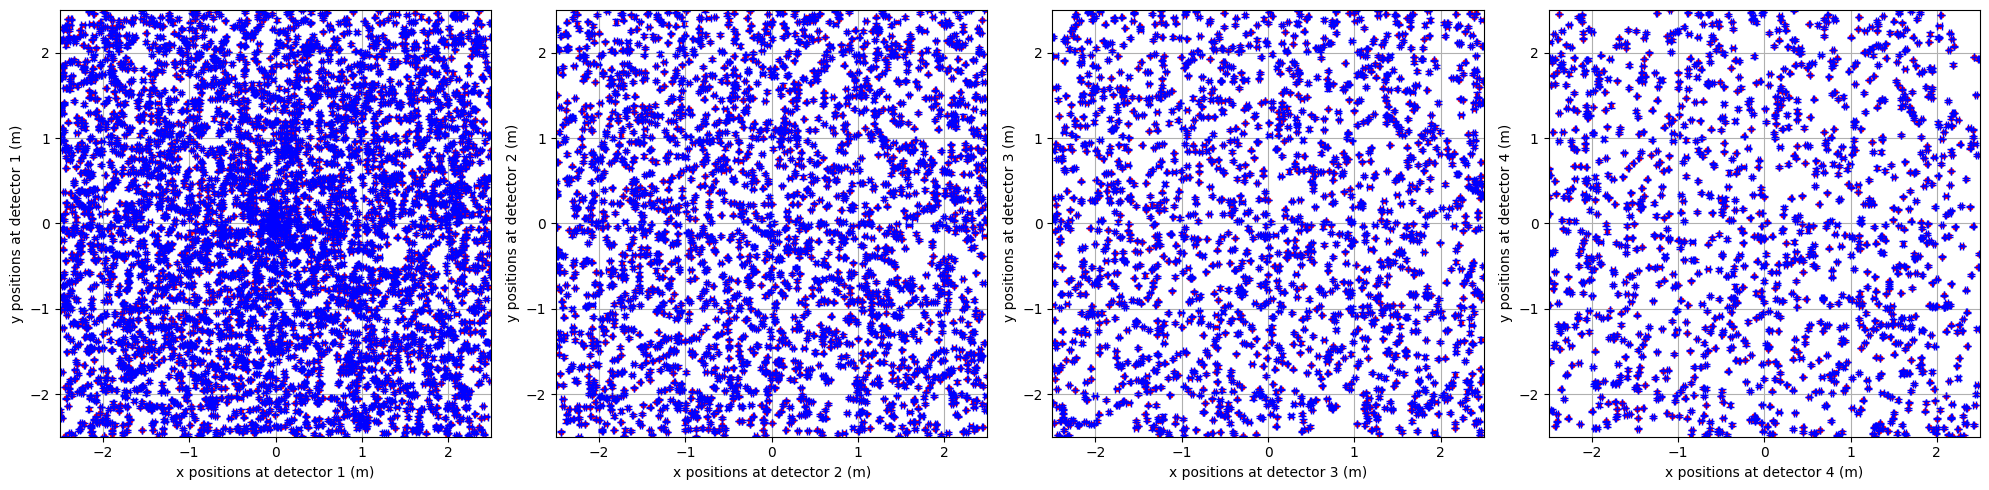

In [112]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax_i in enumerate(axes):
    xcol = f'x{i+1}'
    ycol = f'y{i+1}'
    mask = (run[xcol] != 0) | (run[ycol] != 0)  # plot only non-zero hits
    ax_i.scatter(run.loc[mask, xcol], run.loc[mask, ycol], s=10, color='red', marker="X")
    ax_i.errorbar(run.loc[mask, xcol], run.loc[mask, ycol], xerr=run.loc[mask, f'{xcol}_err'], yerr=run.loc[mask, f'{ycol}_err'], fmt='none', ecolor='blue', capsize=3)
    ax_i.set_xlabel(f'x positions at detector {i+1} (m)')
    ax_i.set_ylabel(f'y positions at detector {i+1} (m)')
    ax_i.set_xlim(-2.5, 2.5)
    ax_i.set_ylim(-2.5, 2.5)
    ax_i.grid(True)

plt.tight_layout()
plt.show()

(array([1888.,  751.,  468., 1315.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5]),
 <BarContainer object of 4 artists>)

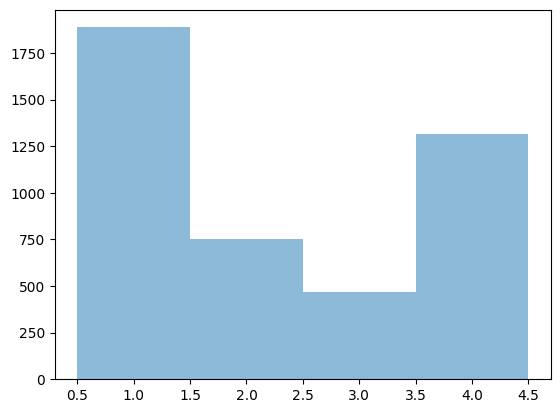

In [113]:
plt.hist(num_hits_list, bins=np.arange(min(num_hits_list)+1, max(num_hits_list) + 2) - 0.5, alpha=0.5)

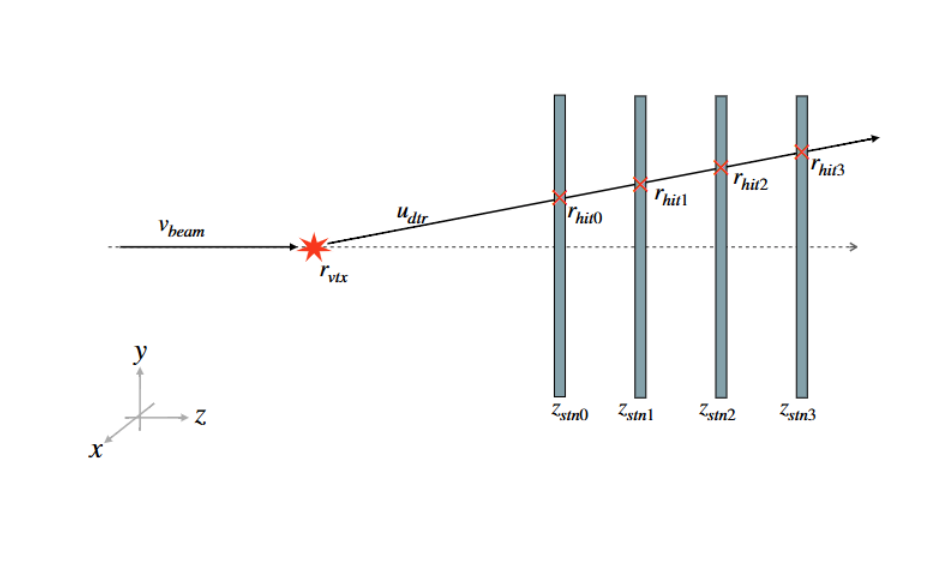



This is a copy of the diagram from the assignment brief. To validate the data from the simulation above, the expected values have been calculated.

Using the base parameters given in the brief and a few others:
* $N = 10^6$ particles
* $\tau = 2.5ms$
* $\mu_v = 2000ms^{-1}$
* $z_{stn} = 30, 35, 40, 45m$
* stn size: $\Delta x = 2a = 5m, \Delta y = 2b = 5m$
* $\sigma_{x, y} = 0.01m$

Therefore, the mean $z$ value of the decay position of the particle, $r_{vtx}$, is 5m which gives a simplistic estimate of the number of particles hitting the first tracking station to be:

$$ N_{1} = N  \frac{\Omega}{4\pi}$$

Here $\Omega$ is the solid angle of the first square detector, given by:

$$ \Omega = 4 \arctan \left(\frac{ab}{R\sqrt{R^2 + a^2 + b^2}}\right)$$

Where $R$ is the distance of the detector from the mean value of $r_{vtx}$. 

However, in reality the number of particles which collide with the first tracking station is much greater as some particles decay closer to the detector than this mean distance of 25 meters and the solid angle increases as $r_{vtx}$ increases. The probability distribution function given above can be multiplied by the equation for the solid angle fraction and the total number of particles, $N$, to give the number of particles expected to decay at a value of $z$ and still collide with the first racking station, $A(z)$. Integrating over $z$ will then display the total number of particles incident on the first tracking station, $N_{1}$:

$$ A(z) = N \left(\frac{\lambda}{\sqrt{2 \pi \sigma}} \int_0^\infty \frac{1}{b} e^{\left(-\frac{(z/b-\mu)^2}{2\sigma^2}-\lambda b\right)}db \right ) \left( \frac{4 \arctan \left(\frac{ab}{R\sqrt{R^2 + a^2 + b^2}}\right)}{4 \pi} \right)$$

for $N = 10^6$:

$$ N_{1} = \int_0^{30} A(z) dz = 4505 $$

As all particles are assumed to travel linearly, no particles which miss detector one can hit any of the later detectors. 




In [115]:
particles_with_hits = (run['x1'] != 0).sum()

Markdown(f"Total number to hit any detectors: {particles_with_hits}")

Total number to hit any detectors: 4422

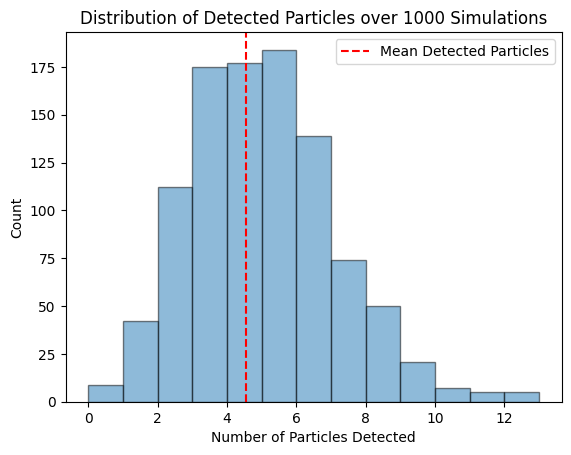

4.548


In [117]:
num_tests = 1000
num_particles = 1000
mean_v = 2000
std_v = 100
Lambda = 0.0025
detector_positions = [30, 35, 40, 45]

num_hits_run = []


for test in range(num_tests):

    run, num_hits_list = simulation(num_particles, mean_v, std_v, Lambda, detector_positions)
    particles_with_hits = (run['x1'] != 0).sum()
    num_hits_run.append(particles_with_hits)

plt.hist(num_hits_run, bins=13, alpha=0.5, edgecolor='black')
plt.xlabel('Number of Particles Detected')
plt.ylabel('Count')
plt.title('Distribution of Detected Particles over 1000 Simulations')
plt.axvline(x=np.mean(num_hits_run), color='r', linestyle='--', label='Mean Detected Particles')
plt.legend()
plt.show()


print(np.mean(num_hits_run))